In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

from DataLoader.DataLoader import DataLoader
from DataLoader.DataBasedAgent import DataBasedAgent
from DataLoader.DataRLAgent import DataRLAgent
import DeepRLAgent.VanillaInput.Train as Train
from PatternDetectionInCandleStick.Evaluation import Evaluation
import distinctipy

import plotly.graph_objs as go
from kaleido.scopes.plotly import PlotlyScope

from importlib import reload
import shutil

Train = reload(Train)
DeepRL = Train.Train
from utils_best_arm import add_train_portfo, add_test_portfo, plot_return, calc_return, plot_action_point, setup_logger
pd.options.display.max_colwidth = 100

device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CURRENT_PATH = os.getcwd()
plt.rcParams["font.size"] = 14
plt.rcParams["text.color"] = "black"

# plt.style.use("ggplot")

In [42]:
# NOTE: 把profit_5的pkl文件拿过来
# symbols = os.listdir("./Data/")[:10]
# for symbol in symbols:
#     for seed in range(100):
#         src = f"../try7_with_regularizezd_rewards_exp3/Results/{symbol}/2016-01-01~2019-01-01/{seed}/train/model_profit_0_{seed}.pkl"
#         dst = f"./Results/{symbol}/2016-01-01~2019-01-01/{seed}/train/model_profit_0_{seed}.pkl"
#         shutil.copy(dst=dst, src=src)


In [58]:

def plot_action_point(dataTest_agent, data_loader, symbol, name, begin=0, end=120):

    data_test = dataTest_agent
    df1 = data_loader.data_test_with_date[begin:end]

    actionlist = list(data_test.data[data_test.action_name][begin:end])
    df1[data_test.action_name] = actionlist

    buy = df1.copy()
    sell = df1.copy()
    none = df1.copy()

    # NOTE 应该画在close处比较合适吧
    buy['action'] = [c if a == 'buy' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
    sell['action'] = [c if a == 'sell' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
    none['action'] = [c if a == 'None' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]

    data=[
        go.Candlestick(name = "", showlegend = False, x=df1.index, open=df1['open'], high=df1['high'], low=df1['low'], close=df1['close'], increasing_line_color= 'lightgreen', decreasing_line_color= '#ff6961'),
        go.Scatter(x=df1.index, y=buy.action, mode = 'markers', marker=dict(color='red', colorscale='Viridis'), name="buy"), 
        go.Scatter(x=df1.index, y=none.action, mode = 'markers', marker=dict(color='blue', colorscale='Viridis'), name="hold"), 
        go.Scatter(x=df1.index, y=sell.action, mode = 'markers', marker=dict(color='green', colorscale='Viridis'), name="sell")
    ]

    layout = go.Layout(
        autosize = False,
        width = 1000,
        height = 400,
        margin=dict(l=20, r=20, t=20, b=20),
        xaxis_rangeslider_visible=False,
        xaxis_title = "date",
        yaxis_title = "adjusted close",
        font = {
            "size": 18,
        }
    )
    
    figSignal = go.Figure(data=data, layout=layout)
    figSignal.write_image(
        f"./ActionsPlot/{symbol}-{name}.png", 
        engine="kaleido", 
        scale=2, 
        # width=1280, 
        # height=500
    )
    
    figSignal.show()
    # scope = PlotlyScope()
    # with open(f"./ActionsPlot/{symbol}-{name}.png", "wb") as f:
    #     f.write(scope.transform(figSignal, format="png", scale=2))


In [59]:
def train(
    DATASET_NAME, 
    split_point='2018-01-01', 
    begin_date='2010-01-01', 
    end_date='2020-08-24', 
    model_start_date="",
    model_end_date="",
    initial_investment=1000,
    transaction_cost=0.0001,
    load_from_file=True,
    reward_type="profit",
    seed=42, 
    state_mode=1,
    n_episodes=5,
    lamb=0.0001,
    GAMMA=0.7, 
    n_step=5, 
    BATCH_SIZE=10, 
    ReplayMemorySize=20,
    TARGET_UPDATE=5,
    window_size=None, 
    train_portfolios={},
    test_portfolios={},
    arms=[],
    show_all = False,
    ratio_threshold=0.9,
):
    data_loader = DataLoader(DATASET_NAME, split_point=split_point, begin_date=begin_date, end_date=end_date, load_from_file=load_from_file)
    
    dataTrain_agent = DataRLAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_agent = DataRLAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    agent = DeepRL(data_loader, dataTrain_agent, dataTest_agent, 
                DATASET_NAME,  state_mode, window_size, transaction_cost,
                BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                TARGET_UPDATE=TARGET_UPDATE, n_step=n_step, arms=arms)
    
    path = f"./Results/{DATASET_NAME}/{model_start_date}~{model_end_date}/{seed}/train"
    arm = arms[0]
    name = f'{arm["name"]}_{arm["lamb"]}'
    model_path = f"{path}/model_{name}_{seed}.pkl"
    agent_test = agent.test(initial_investment=initial_investment, test_type='test', model_path=model_path)
    test_portfolio = agent_test.get_daily_portfolio_value()
    test_portfolio = pd.Series(test_portfolio).pct_change(1).fillna(0).values.tolist() 
    model_name = f'DQN-stock:{DATASET_NAME}-reward:{name}-seed:{seed}'
    plot_action_point(dataTest_agent, data_loader, DATASET_NAME, name, begin=0, end=100)
    return data_loader, {"name": model_name, "portfo": test_portfolio}

In [60]:
files = sorted(os.listdir("./Data/"))
files[2:3]

['AXP']

In [61]:
initial_investment = 1000


kwargs = {
    "load_from_file": True, 
    "transaction_cost": 0.0000,
    "initial_investment": initial_investment,
    "state_mode": 1,
    "GAMMA": 0.7, 
    "n_step": 5, 
    "BATCH_SIZE": 10, 
    "ReplayMemorySize": 20,
    "TARGET_UPDATE": 5,
    "window_size": None, 
    "lamb": 0.0,
}

_file = "AAPL"

_begin_date = '20{}-01-01'
_end_date = '20{}-01-01'
_split_point = '20{}-01-01' 

arms = [
    { "name": "old_profit", "lamb": 0},
    { "name": "old_sharpe", "lamb": 0},
    { "name": "profit", "lamb": 0},
    { "name": "future_profit_1", "lamb": 0},
    { "name": "future_profit_10", "lamb": 0},
    { "name": "future_profit_15", "lamb": 0},
    { "name": "future_profit_20", "lamb": 0},
]

dates = [
    ("2019-06-23", "2020-06-22", "2016-01-01", "2019-01-01"),
    # ("2020-06-22", "2021-06-22", "2017-01-01", "2020-01-01"),
    # ("2021-06-23", "2022-06-23", "2018-01-01", "2021-01-01"),
]

random_seeds = 1
results = []
portfolios_saved = {}
files = sorted(os.listdir("./Data/"))
for _file in files[2:3]:
    print(_file)
    portfolios_saved[_file] = {}
    for idx, arm in enumerate(arms[:]):
        results2 = []
        tmp_result = []
        portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"] = []
        
        for seed in tqdm(range(random_seeds)):
            
            ls = []
            bhs = []
        
            train_portfolios = {}
            test_portfolios = {}

            kwargs.update({
                "begin_date": "2016-01-01", 
                "end_date": "2019-01-01", 
                "split_point": "2018-01-01",
                "model_start_date": "2016-01-01",
                "model_end_date": "2019-01-01",
                "DATASET_NAME": _file,
                "reward_type": "",
                "seed": seed,
                "n_episodes": 20,
                "arms": [arm],
                "show_all": True,
                "ratio_threshold": 3,
                "train_portfolios": train_portfolios,
                "test_portfolios": test_portfolios,
            })

            data_loader, model = train(**kwargs)
            ls.extend(model["portfo"])
            bh = data_loader.data_test_with_date["close"]
            bhs.append(bh)
            
            add_test_portfo(test_portfolios, seed, ls)
            if seed == 0: 
                bhs = pd.concat(bhs, axis=0)
                bh_percentage = bhs.pct_change(1).fillna(0).values
                add_test_portfo(test_portfolios, 'B&H', bh_percentage)
                tmp_result.append(bh_percentage.tolist())
            indexes = calc_return(bh_percentage, test_portfolios)
            results2.append(indexes)
            tmp_result.append(model["portfo"])
        
        portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"] = tmp_result

        results2_df = pd.concat(results2, axis=1)
        results2_bh = results2_df["B&H"]
        del results2_df["B&H"]
        final = pd.concat([
            results2_bh,
            results2_df.median(axis=1)
        ], axis=1)
        
        # path = f"./Results/{_file}/exp1_concat"
        # if not os.path.exists(path):
        #     os.mkdir(path)
        
        # name = f'{arm["name"]}_{arm["lamb"]}'
        # save_path = f"{path}/{name}.csv"
        # pd.DataFrame(portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"]).T.to_csv(save_path, index=False)

        final.columns = [f"{_file}-B&H", f"{_file}-{arm['name']}-{arm['lamb']}"]
        if idx > 0:
            del final[f"{_file}-B&H"]
        results.append(final)


AXP


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [12]:
symbols = list(portfolios_saved.keys())[:10]
ls = []
for symbol in symbols:
    rewards = list(portfolios_saved[symbol].keys()) 
    rewards = ['old_profit-0', "old_sharpe-0", 'future_profit_1-0', 'profit-0', 'future_profit_10-0', 'future_profit_15-0', 'future_profit_20-0',]

    tmp = pd.DataFrame(portfolios_saved[symbol][rewards[0]]).iloc[1:].T.median(axis=1)
    tmp.name = f"{symbol}-B&H"
    # tmp = ((1 + pd.DataFrame(portfolios_saved[symbol][rewards[0]]).iloc[:1].T).cumprod() - 1)
    # tmp.columns = [f"{symbol}-B&H"]
    tmp = tmp.shift(1)
    tmp = tmp.fillna(0)
    ls.append(tmp)

    for reward in rewards:
        tmp = pd.DataFrame(portfolios_saved[symbol][reward]).iloc[1:].T.median(axis=1)
        # tmp = ((1 + pd.DataFrame(portfolios_saved[symbol][reward]).iloc[1:].T).cumprod() - 1).median(axis=1)
        if reward == "old_sharpe-0": reward = "PSR"
        if reward == "old_profit-0": reward = "PP1"
        if reward == "profit-0": reward = "FP5"
        if reward == "future_profit_1-0": reward = "FP1"
        if reward == "future_profit_10-0": reward = "FP10"
        if reward == "future_profit_15-0": reward = "FP15"
        if reward == "future_profit_20-0": reward = "FP20"

        tmp.name = symbol + "-" + reward
        ls.append(tmp)


results_cumreturn = pd.concat(ls, axis=1)
results_cumreturn

,AAPL-B&H,AAPL-PP1,AAPL-PSR,AAPL-FP1,AAPL-FP5,AAPL-FP10,AAPL-FP15,AAPL-FP20,AMGN-B&H,AMGN-PP1,...,DIS-FP15,DIS-FP20,GS-B&H,GS-PP1,GS-PSR,GS-FP1,GS-FP5,GS-FP10,GS-FP15,GS-FP20
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.004645,0.000000e+00,0.004645,0.004645,0.004645,0.004645,0.004645,0.000000,-0.004214,...,-0.000445,-0.000445,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.013976,0.013976,0.013976
3,0.004645,0.000000,0.000000e+00,0.011385,0.011385,0.011385,0.011385,0.011385,-0.004214,0.005958,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.005101,-0.005101,-0.005101,-0.005101,-0.005101
4,0.000000,0.000000,0.000000e+00,-0.003714,-0.003714,-0.003714,-0.003714,-0.003714,0.005958,0.000000,...,0.000000,0.000000,0.000000,-0.014519,0.000000e+00,-0.014519,0.000000,-0.014519,-0.014519,-0.014519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.000000,0.000000,2.220446e-16,0.070421,0.070421,0.070421,0.070421,0.070421,-0.010044,0.000000,...,0.054609,0.054609,-0.023118,0.000000,1.110223e-16,0.042085,0.042085,0.042085,0.042085,0.042085
248,0.000000,-0.006490,-2.775558e-16,-0.006490,-0.006490,-0.006490,-0.006490,-0.006490,0.000000,0.000000,...,0.006520,0.006520,0.000000,0.000000,0.000000e+00,0.015221,0.015221,0.015221,0.015221,0.015221
249,-0.006490,0.000512,2.561323e-04,0.000512,0.000512,0.000512,0.000512,0.000512,0.000000,0.002102,...,0.007323,0.007323,0.000000,-0.014389,0.000000e+00,-0.014389,-0.014389,-0.014389,-0.014389,-0.014389
250,0.000512,0.009665,1.110223e-16,0.009665,0.009665,0.009665,0.009665,0.009665,0.002102,0.020658,...,0.021901,0.021901,-0.014389,0.024658,0.000000e+00,0.024658,0.024658,0.024658,0.024658,0.024658


In [13]:
dates = list(bhs[0].index)

total_df = pd.concat([
    pd.DataFrame(dates), 
    results_cumreturn
], axis=1)
total_df["date"] = total_df.iloc[:, 0].copy()
total_df = total_df.set_index("date")
total_df = total_df.iloc[:, 1:]
cols = list(total_df.columns)[:]
for idx, col in enumerate(cols):
    if isinstance(col, int):
        _col = f"{cols[idx+1]}-B&H"
        total_df = total_df.rename({col: _col}, axis=1)
        total_df[_col] = total_df[_col].shift(-1)


total_df = total_df.reset_index()
total_df = total_df.dropna()
# total_df.to_csv("./ts-run-results/[exp1]returns.csv", index=False)
# total_df.to_csv("./ts-run-results/[exp1]cumreturns.csv", index=False)
total_df

,date,AAPL-B&H,AAPL-PP1,AAPL-PSR,AAPL-FP1,AAPL-FP5,AAPL-FP10,AAPL-FP15,AAPL-FP20,AMGN-B&H,...,DIS-FP15,DIS-FP20,GS-B&H,GS-PP1,GS-PSR,GS-FP1,GS-FP5,GS-FP10,GS-FP15,GS-FP20
0,2018-01-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-01-03,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2018-01-04,0.000000,0.004645,0.000000e+00,0.004645,0.004645,0.004645,0.004645,0.004645,0.000000,...,-0.000445,-0.000445,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.013976,0.013976,0.013976
3,2018-01-05,0.004645,0.000000,0.000000e+00,0.011385,0.011385,0.011385,0.011385,0.011385,-0.004214,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.005101,-0.005101,-0.005101,-0.005101,-0.005101
4,2018-01-08,0.000000,0.000000,0.000000e+00,-0.003714,-0.003714,-0.003714,-0.003714,-0.003714,0.005958,...,0.000000,0.000000,0.000000,-0.014519,0.000000e+00,-0.014519,0.000000,-0.014519,-0.014519,-0.014519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-24,0.000000,0.000000,-1.293699e-02,-0.025874,-0.025874,-0.025874,-0.025874,-0.025874,0.000000,...,-0.037133,-0.037133,0.000000,-0.023118,0.000000e+00,0.000000,0.000000,0.000000,-0.023118,-0.023118
247,2018-12-26,0.000000,0.000000,2.220446e-16,0.070421,0.070421,0.070421,0.070421,0.070421,-0.010044,...,0.054609,0.054609,-0.023118,0.000000,1.110223e-16,0.042085,0.042085,0.042085,0.042085,0.042085
248,2018-12-27,0.000000,-0.006490,-2.775558e-16,-0.006490,-0.006490,-0.006490,-0.006490,-0.006490,0.000000,...,0.006520,0.006520,0.000000,0.000000,0.000000e+00,0.015221,0.015221,0.015221,0.015221,0.015221
249,2018-12-28,-0.006490,0.000512,2.561323e-04,0.000512,0.000512,0.000512,0.000512,0.000512,0.000000,...,0.007323,0.007323,0.000000,-0.014389,0.000000e+00,-0.014389,-0.014389,-0.014389,-0.014389,-0.014389


In [12]:
# df1 = pd.read_csv("./ts-run-results/[exp1][1]returns.csv")
# cols_old = [col  for col in df1.columns if "sharpe" in col]
# cols_new = [f'{col.split("-")[0]}-PSR'  for col in df1.columns if "sharpe" in col]
# df1 = df1.rename({o:n for o, n in zip(cols_old, cols_new)}, axis=1)

# df2 = pd.read_csv("./ts-run-results/[exp1]returns.csv")
# df2[cols_new] = df1[cols_new]
# df2.to_csv("./ts-run-results/[exp1][3]returns.csv")
# df2

,date,AAPL-B&H,AAPL-PP1,AAPL-PSR,AAPL-FP1,AAPL-FP5,AAPL-FP10,AAPL-FP15,AAPL-FP20,AMGN-B&H,...,DIS-FP15,DIS-FP20,GS-B&H,GS-PP1,GS-PSR,GS-FP1,GS-FP5,GS-FP10,GS-FP15,GS-FP20
0,2018-01-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-01-03,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2018-01-04,0.000000,0.004645,0.000000e+00,0.004645,0.004645,0.004645,0.004645,0.004645,0.000000,...,-0.000445,-0.000445,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.013976,0.013976,0.013976
3,2018-01-05,0.004645,0.000000,0.000000e+00,0.011385,0.011385,0.011385,0.011385,0.011385,-0.004214,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.005101,-0.005101,-0.005101,-0.005101,-0.005101
4,2018-01-08,0.000000,0.000000,0.000000e+00,-0.003714,-0.003714,-0.003714,-0.003714,-0.003714,0.005958,...,0.000000,0.000000,0.000000,-0.014519,0.000000e+00,-0.014519,0.000000,-0.014519,-0.014519,-0.014519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-24,0.000000,0.000000,0.000000e+00,-0.025874,-0.025874,-0.025874,-0.025874,-0.025874,0.000000,...,-0.037133,-0.037133,0.000000,-0.023118,0.000000e+00,0.000000,0.000000,0.000000,-0.023118,-0.023118
247,2018-12-26,0.000000,0.000000,1.110223e-16,0.070421,0.070421,0.070421,0.070421,0.070421,-0.010044,...,0.054609,0.054609,-0.023118,0.000000,2.220446e-16,0.042085,0.042085,0.042085,0.042085,0.042085
248,2018-12-27,0.000000,-0.006490,-3.244769e-03,-0.006490,-0.006490,-0.006490,-0.006490,-0.006490,0.000000,...,0.006520,0.006520,0.000000,0.000000,1.522135e-02,0.015221,0.015221,0.015221,0.015221,0.015221
249,2018-12-28,-0.006490,0.000512,0.000000e+00,0.000512,0.000512,0.000512,0.000512,0.000512,0.000000,...,0.007323,0.007323,0.000000,-0.014389,0.000000e+00,-0.014389,-0.014389,-0.014389,-0.014389,-0.014389


In [17]:
# df1 = pd.read_csv("./ts-run-results/[exp1][1]cumreturns.csv")
# cols_old = [col  for col in df1.columns if "sharpe" in col]
# cols_new = [f'{col.split("-")[0]}-PSR'  for col in df1.columns if "sharpe" in col]
# df1 = df1.rename({o:n for o, n in zip(cols_old, cols_new)}, axis=1)

# df2 = pd.read_csv("./ts-run-results/[exp1]cumreturns.csv")
# df2[cols_new] = df1[cols_new]
# df2.to_csv("./ts-run-results/[exp1][3]cumreturns.csv")
# df2

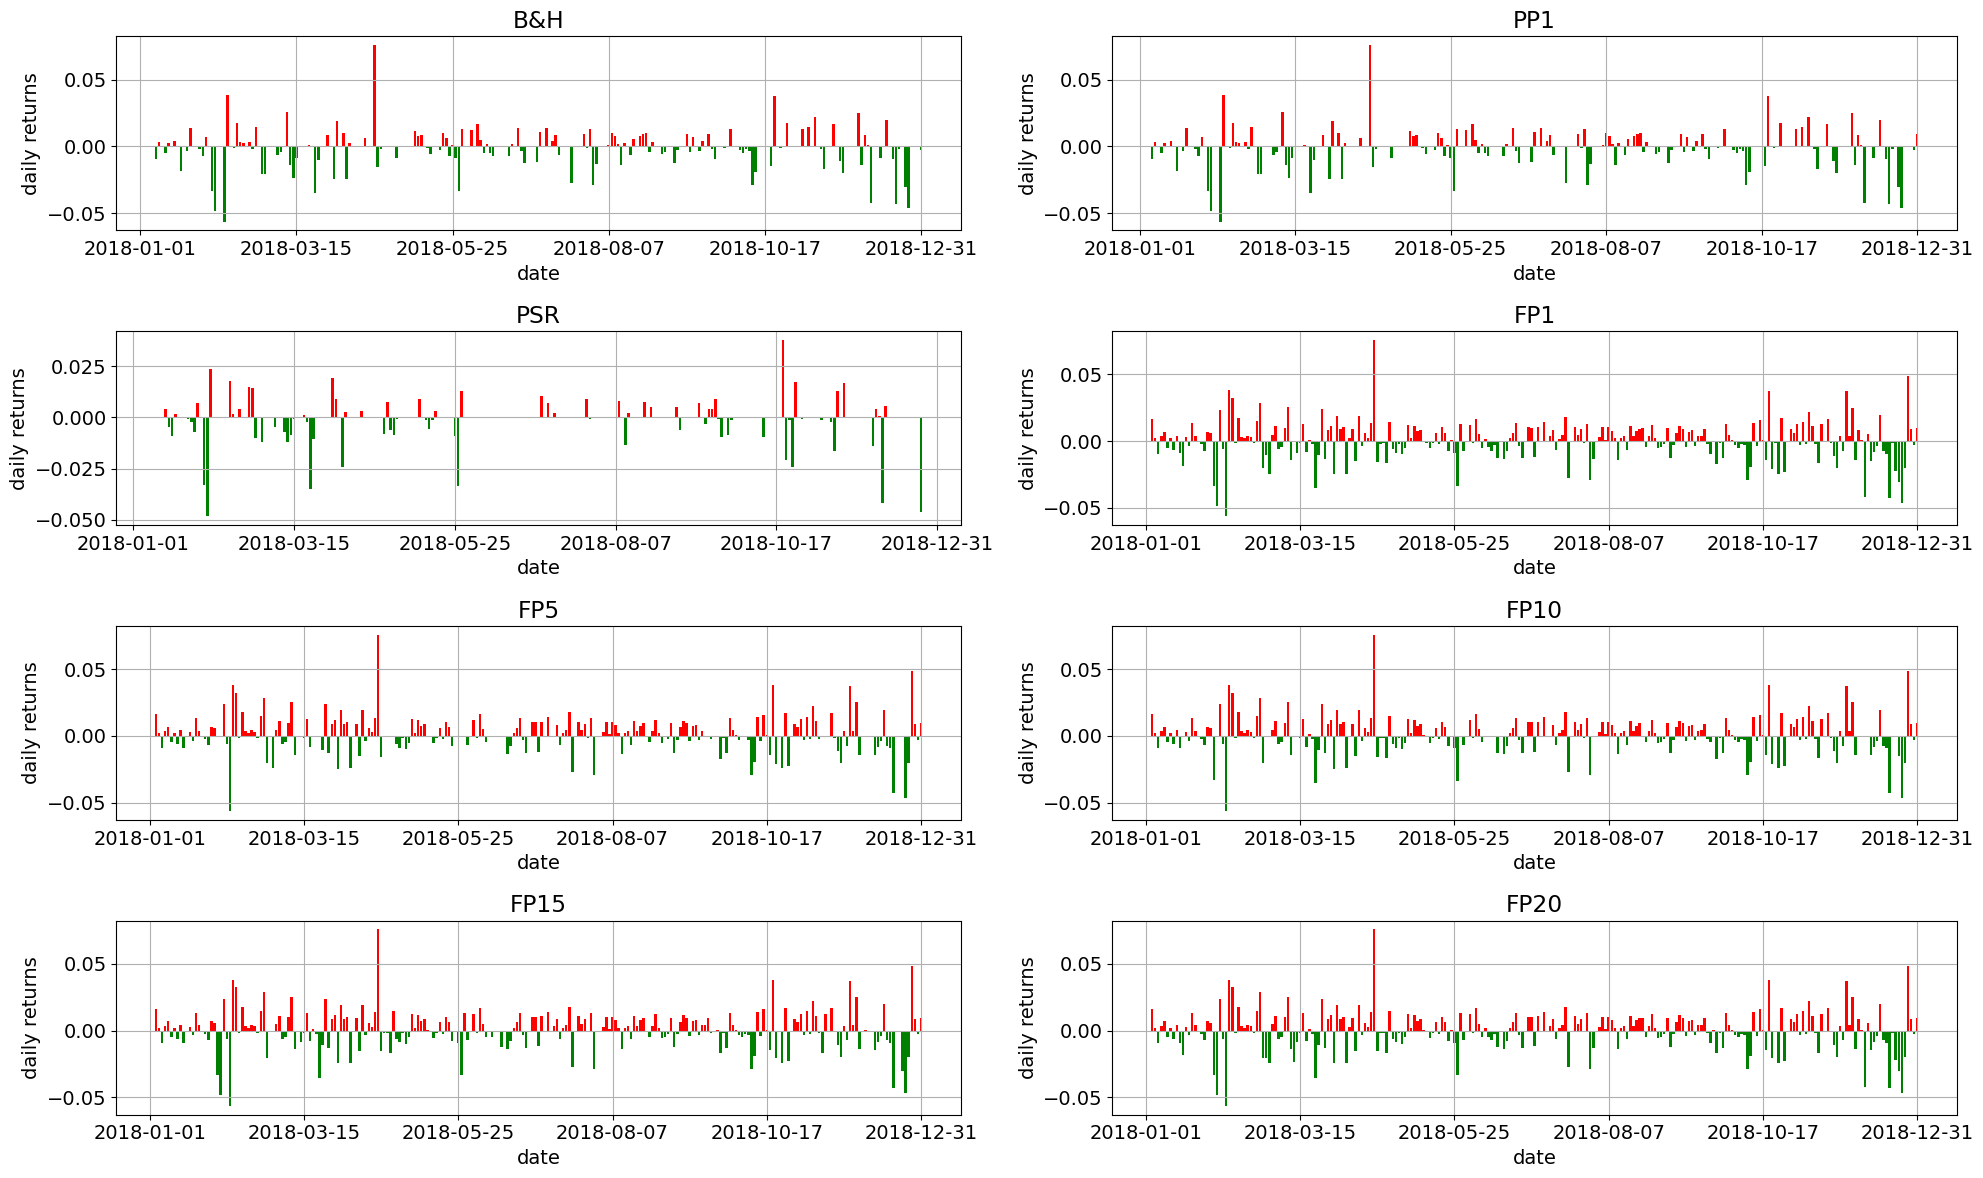

In [15]:
total_df = pd.read_csv("./ts-run-results/[exp1][3]returns.csv")

fig, axes = plt.subplots(4, 2, figsize=(20, 12))
axes = axes.reshape(-1)
cols = [col for col in list(total_df.columns) if "AXP" in col]
for i, col in enumerate(cols[:]):
    tmp = total_df[col]
    tmp_up = tmp[tmp > 0]
    tmp_down = tmp[tmp < 0]
    axes[i].bar(list(tmp_up.index), tmp_up, color="red")
    axes[i].bar(list(tmp_down.index), tmp_down, color="green")
    axes[i].grid()
    length = list(tmp.index).__len__()
    indexes = [_len for _len in range(0, length+1, 50)]
    dates = [list(total_df["date"])[_len] for _len in indexes]
    dates[0] = "2018-01-01"
    axes[i].set_xticks(indexes, dates)
    if "old_sharpe" in col:
        name = "PSR"
    else:
        name = col.split("-")[1]
    axes[i].set_title(name)
    axes[i].set_xlabel("date")
    axes[i].set_ylabel("daily returns")

plt.tight_layout()
plt.savefig("./pictures/2-experiment1-AXP-daily-return.eps")
plt.show()

# NOTE 计算各类指标

In [41]:
results_df = pd.concat(results, axis=1)
ls = []
for symbol in symbols:
    
    results_df = results_df.rename({
        f"{symbol}-profit-0": f"{symbol}-FP5",
        f"{symbol}-old_sharpe-0": f"{symbol}-PSR",
        f"{symbol}-old_profit-0": f"{symbol}-PP1",
        f"{symbol}-future_profit_1-0": f"{symbol}-FP1",
        f"{symbol}-future_profit_10-0": f"{symbol}-FP10",
        f"{symbol}-future_profit_15-0": f"{symbol}-FP15",
        f"{symbol}-future_profit_20-0": f"{symbol}-FP20",
    }, axis=1)
    cols = [col for col in results_df.columns if symbol in col]
    tmp = results_df[cols]
    cols.remove(f"{symbol}-FP5")
    cols.insert(3, f"{symbol}-FP5")
    tmp = tmp[cols]
    ls.append(tmp)

results_df = pd.concat(ls, axis=1)
results_df.to_csv(f"./ts-run-results/[exp1][2]returns的各类指标.csv")
results_df

,AAPL-B&H,AAPL-PP1,AAPL-PSR,AAPL-FP5,AAPL-FP1,AAPL-FP10,AAPL-FP15,AAPL-FP20,AMGN-B&H,AMGN-PP1,...,DIS-FP15,DIS-FP20,GS-B&H,GS-PP1,GS-PSR,GS-FP5,GS-FP1,GS-FP10,GS-FP15,GS-FP20
sortino_test,-0.157630,-0.514697,-0.108198,3.084893,1.458770,2.619921,0.464488,-0.093020,0.839055,-1.184955,...,4.073443,3.346047,-2.028436,-2.123898,-1.022825,4.134506,3.319157,2.193084,1.734996,-1.954443
sharpe_test,-0.113196,-0.513556,-0.102512,2.048742,0.986098,1.807858,0.341310,-0.067147,0.645047,-1.300157,...,2.636172,2.265180,-1.485293,-2.260472,-1.011028,2.615134,2.141579,1.554041,1.263956,-1.439297
risk_test,0.286281,0.204463,0.200152,0.228592,0.243656,0.245387,0.277841,0.285987,0.236947,0.175835,...,0.156662,0.166179,0.255982,0.193913,0.162124,0.177934,0.178441,0.195083,0.202395,0.255378
mdd_test,0.365095,0.287018,0.249900,0.180061,0.251084,0.216129,0.305326,0.365095,0.155024,0.293094,...,0.061152,0.075590,0.421830,0.385210,0.290733,0.099822,0.119041,0.150697,0.178997,0.420924
downrisk_test,0.205582,0.210251,0.196479,0.150923,0.172213,0.169289,0.204766,0.205514,0.182160,0.192095,...,0.100703,0.111074,0.187439,0.207591,0.183926,0.111089,0.114334,0.132098,0.144355,0.188095
cumreturn_test,-0.070543,-0.123966,-0.045795,0.561507,0.204472,0.509171,0.057579,-0.058160,0.132149,-0.215782,...,0.486238,0.438060,-0.337619,-0.368024,-0.177385,0.559307,0.433413,0.334539,0.251690,-0.328760


In [175]:
# results_df[[col for col in results_df.columns if "AXP" in col]]

# NOTE 画累计收益图

In [19]:
dates_ls = ['2018-01-01',
 '2018-03-05',
 '2018-05-03',
 '2018-07-03',
 '2018-08-31',
 '2018-10-31',
 '2018-12-31']
dates_index = [42 * i for i in range(7)]


In [20]:
results_cumreturn2 = pd.read_csv("./ts-run-results/[exp1][3]cumreturns.csv")
results_cumreturn2 

,Unnamed: 0,date,AAPL-B&H,AAPL-PP1,AAPL-PSR,AAPL-FP1,AAPL-FP5,AAPL-FP10,AAPL-FP15,AAPL-FP20,...,DIS-FP15,DIS-FP20,GS-B&H,GS-PP1,GS-PSR,GS-FP1,GS-FP5,GS-FP10,GS-FP15,GS-FP20
0,0,2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2018-01-04,-0.000174,0.004645,0.000000,0.004645,0.004645,0.004645,0.004645,0.004645,...,-0.000445,-0.000445,-0.009309,0.000000,0.000000,0.000000,0.000000,0.013976,0.013976,0.013976
3,3,2018-01-05,0.004470,0.004645,0.004645,0.016083,0.016083,0.016083,0.016083,0.016083,...,-0.000445,-0.000445,0.004537,0.000000,0.000000,-0.005101,-0.005101,0.008804,0.008804,0.008804
4,4,2018-01-08,0.015906,0.004645,0.000914,0.012309,0.012309,0.012309,0.012309,0.012309,...,-0.000445,-0.000445,-0.000587,-0.014519,0.000000,-0.019546,-0.005101,-0.005843,-0.005843,-0.005843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,246,2018-12-24,-0.111849,-0.127132,-0.000056,0.121166,0.453507,0.404790,-0.014314,-0.123302,...,0.360182,0.316090,-0.365375,-0.374229,-0.182072,0.342022,0.461070,0.249059,0.181610,-0.371754
247,247,2018-12-26,-0.134829,-0.127132,0.000000,0.200120,0.555865,0.503717,0.053757,-0.061564,...,0.434460,0.387960,-0.380046,-0.374229,-0.165292,0.398060,0.522559,0.301625,0.220979,-0.345315
248,248,2018-12-27,-0.073902,-0.132796,0.000000,0.192331,0.545768,0.493959,0.046918,-0.067654,...,0.443813,0.397010,-0.353955,-0.374229,-0.158968,0.419341,0.545734,0.321437,0.239401,-0.335350
249,249,2018-12-28,-0.079912,-0.132352,0.000000,0.192942,0.546560,0.494724,0.047455,-0.067176,...,0.454385,0.407239,-0.344121,-0.383233,-0.165037,0.398918,0.523494,0.302424,0.221568,-0.344913


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


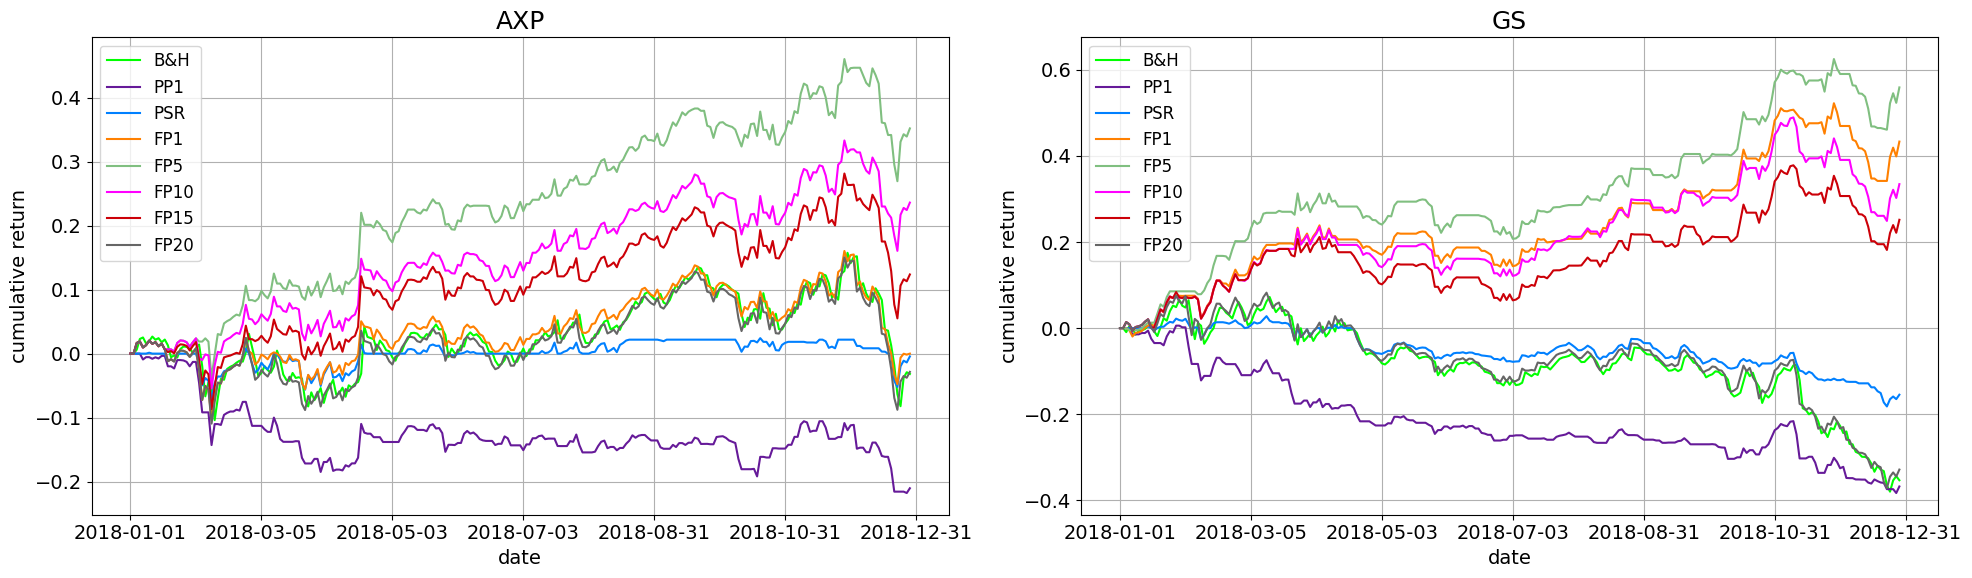

In [23]:

symbols = os.listdir("./Data/")[:10]

# plt.style.use('seaborn-white')
# plt.rcParams["text.color"] = "black"

colors = [
    (0.0, 1.0, 0.0),
    (0.4, 0.1, 0.6),
    (0.0, 0.5, 1.0),
    (1.0, 0.5, 0.0),
    (0.5, 0.75, 0.5),
    (1.0, 0.0, 1.0),
    (0.8, 0.0, 0.03),
    (0.4, 0.4, 0.4)
]
names = ["B&H",	"PP1", "PSR", "FP1", "FP5", "FP10", "FP15", "FP20",]
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
# fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.reshape(-1)
symbols = ["AXP", "GS"]
for i, symbol in enumerate(symbols):
    cols = [col for col in results_cumreturn2.columns if symbol in col]
    tmp = results_cumreturn2[cols]
    for j, col in enumerate(cols):
        axes[i].plot(tmp[col], label=names[j], color=colors[j])
    max_value = np.max(tmp.max())
    axes[i].set_xticks(dates_index, dates_ls, fontsize=14)
    axes[i].set_title(symbol, fontsize=18)
    axes[i].set_xlabel("date", fontsize=14)
    axes[i].set_ylabel("cumulative return", fontsize=14)
    if symbol == "CAT":
        loc = "lower left"
    else:
        loc = "upper left"
    axes[i].legend(fontsize=12, loc=loc,)
    axes[i].grid()


plt.tight_layout()
# plt.savefig("./pictures/2-experiment1.eps")
plt.savefig("./pictures/2-experment1-part.eps")
plt.show()

# NOTE 转latex table

In [26]:
import pandas as pd

results_df = pd.read_csv(f"./ts-run-results/[exp1][2]returns的各类指标.csv", index_col=[0])
cols = list(results_df.columns)
symbols = []
for col in cols:
    symbols.append(col.split("-")[0])

symbols = sorted(list(set(symbols)))
symbols

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS']

In [27]:
def find(symbol):
    cols = [col for col in results_df.columns if symbol in col]
    
    tmp = results_df[cols]
    cols = [col.split("-")[1] for col in list(tmp.columns)]
    tmp.columns = cols
    tmp = tmp.T
    cols = [col.split("_")[0] for col in list(tmp.columns)]
    tmp.columns = cols
    tmp = tmp.T[["B&H", "PP1", "PSR", "FP1", "FP5", "FP10", "FP15", "FP20"]].T
    tmp.columns = ["STR", "SR", "Risk", "MDD", "DR", "CR"]
    tmp = tmp[["CR", "STR", "SR", "MDD", "Risk", "DR"]]
    return tmp

In [29]:
ls = []
for symbol in symbols:
    tmp = find(symbol)
    tmp["symbol"] = symbol
    tmp = tmp.reset_index()
    tmp = tmp.set_index(["symbol", "index"])
    ls.append(tmp)
res_df = pd.concat(ls)
res_df = res_df.round(6)
res_df.to_csv("./ts-run-results/[exp1][2]合并的评价指标.csv")
res_df

CR       STR        SR       MDD      Risk        DR
symbol index                                                            
AAPL   B&H   -0.070543 -0.157630 -0.113196  0.365095  0.286281  0.205582
       PP1   -0.123966 -0.514697 -0.513556  0.287018  0.204463  0.210251
       PSR   -0.045795 -0.108198 -0.102512  0.249900  0.200152  0.196479
       FP1    0.204472  1.458770  0.986098  0.251084  0.243656  0.172213
       FP5    0.561507  3.084893  2.048742  0.180061  0.228592  0.150923
...                ...       ...       ...       ...       ...       ...
GS     FP1    0.433413  3.319157  2.141579  0.119041  0.178441  0.114334
       FP5    0.559307  4.134506  2.615134  0.099822  0.177934  0.111089
       FP10   0.334539  2.193084  1.554041  0.150697  0.195083  0.132098
       FP15   0.251690  1.734996  1.263956  0.178997  0.202395  0.144355
       FP20  -0.328760 -1.954443 -1.439297  0.420924  0.255378  0.188095

[80 rows x 6 columns]

In [32]:
def convert_latex(symbol, _df):
    template = "\\begin{table}[H]\n" + \
        "    \\label{table:" + symbol + "}\n" + \
        "    \\caption{" + symbol + "}\n" + \
        "    \\begin{tabular}{l c c c c c c}\n" + \
        "    \\hline\n" + \
        "                     & CR & STR &	SR &  MDD    &  Risk &	DR     \\\ \n" + \
        "    \\hline\n" + \
        f"    B\\&H	         &  {_df['CR'].iloc[0]:.6f} & {_df['STR'].iloc[0]:.6f}	& {_df['SR'].iloc[0]:.6f} &  {_df['MDD'].iloc[0]:.6f} &  {_df['Risk'].iloc[0]:.6f}   & 	{_df['DR'].iloc[0]:.6f}        \\\ \n" + \
        f"    PP1	             &  {_df['CR'].iloc[1]:.6f} & {_df['STR'].iloc[1]:.6f}	& {_df['SR'].iloc[1]:.6f} & 	{_df['MDD'].iloc[1]:.6f} &  {_df['Risk'].iloc[1]:.6f}   & 	{_df['DR'].iloc[1]:.6f}        \\\ \n" + \
        f"    PSR	             &  {_df['CR'].iloc[2]:.6f} & {_df['STR'].iloc[2]:.6f}	& {_df['SR'].iloc[2]:.6f} & 	{_df['MDD'].iloc[2]:.6f} &  {_df['Risk'].iloc[2]:.6f}   & 	{_df['DR'].iloc[2]:.6f}        \\\ \n" + \
        f"    FP1              &	{_df['CR'].iloc[3]:.6f} & {_df['STR'].iloc[3]:.6f}	& {_df['SR'].iloc[3]:.6f} & 	{_df['MDD'].iloc[3]:.6f} &  {_df['Risk'].iloc[3]:.6f}   & 	{_df['DR'].iloc[3]:.6f}        \\\ \n" + \
        f"    FP5              &  {_df['CR'].iloc[4]:.6f} & {_df['STR'].iloc[4]:.6f}	& {_df['SR'].iloc[4]:.6f} & 	{_df['MDD'].iloc[4]:.6f} &  {_df['Risk'].iloc[4]:.6f}   & 	{_df['DR'].iloc[4]:.6f}        \\\ \n" + \
        f"    FP10	         &  {_df['CR'].iloc[5]:.6f} & {_df['STR'].iloc[5]:.6f}	& {_df['SR'].iloc[5]:.6f} & 	{_df['MDD'].iloc[5]:.6f} &  {_df['Risk'].iloc[5]:.6f}   & 	{_df['DR'].iloc[5]:.6f}        \\\ \n" + \
        f"    FP15	         &  {_df['CR'].iloc[6]:.6f} & {_df['STR'].iloc[6]:.6f}	& {_df['SR'].iloc[6]:.6f} & 	{_df['MDD'].iloc[6]:.6f} &  {_df['Risk'].iloc[6]:.6f}   & 	{_df['DR'].iloc[6]:.6f}        \\\ \n" + \
        f"    FP20	         &  {_df['CR'].iloc[7]:.6f} & {_df['STR'].iloc[7]:.6f}	& {_df['SR'].iloc[7]:.6f} & 	{_df['MDD'].iloc[7]:.6f} &  {_df['Risk'].iloc[7]:.6f}   & 	{_df['DR'].iloc[7]:.6f}        \\\ \n" + \
        "    \hline\n" + \
        "    \end{tabular}\n" + \
    "\\end{table}\n"
    print(template)

In [34]:
symbols

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS']

In [35]:
for symbol in symbols[:]:
    convert_latex(symbol, find(symbol))


\begin{table}[H]
    \label{table:AAPL}
    \caption{AAPL}
    \begin{tabular}{l c c c c c c}
    \hline
                     & CR & STR &	SR &  MDD    &  Risk &	DR     \\ 
    \hline
    B\&H	         &  -0.070543 & -0.157630	& -0.113196 &  0.365095 &  0.286281   & 	0.205582        \\ 
    PP1	             &  -0.123966 & -0.514697	& -0.513556 & 	0.287018 &  0.204463   & 	0.210251        \\ 
    PSR	             &  -0.045795 & -0.108198	& -0.102512 & 	0.249900 &  0.200152   & 	0.196479        \\ 
    FP1              &	0.204472 & 1.458770	& 0.986098 & 	0.251084 &  0.243656   & 	0.172213        \\ 
    FP5              &  0.561507 & 3.084893	& 2.048742 & 	0.180061 &  0.228592   & 	0.150923        \\ 
    FP10	         &  0.509171 & 2.619921	& 1.807858 & 	0.216129 &  0.245387   & 	0.169289        \\ 
    FP15	         &  0.057579 & 0.464488	& 0.341310 & 	0.305326 &  0.277841   & 	0.204766        \\ 
    FP20	         &  -0.058160 & -0.093020	& -0.067147 & 	0.365095 &  0.285987   & 	0.205